# HR Analysis:
## This Notebook works off of example HR data found here: https://www.kaggle.com/datasets/rhuebner/human-resources-data-set?resource=download
## Codebook found here: https://rpubs.com/rhuebner/hrd_cb_v14
## For the sake of the code, using 3/1/2019 as the current date

In [25]:
# Install required libraries
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from autoviz.AutoViz_Class import AutoViz_Class
import plotly
import plotly_express as px
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

In [48]:
# Read data in and print out summary
df = pd.read_csv("HRDataset_v14.csv",delimiter = ",")

def quick_df_report(df):
    print("Data types:\n", df.dtypes)
    print("\nSummary statistics:\n", df.describe())
    print("\nMissing values by column:\n", df.isna().sum().loc[lambda x: x > 0].sort_values(ascending=False)
)

quick_df_report(df)

# Known issue with ManagerID. Apply function to fix missing Manager ID's instead of mapping to just the manager name
print(df.groupby(['ManagerName', 'ManagerID'], dropna=False).size().sort_values(ascending=False))

manager_id_map = (
    df[df['ManagerID'].notna()]
    .groupby('ManagerName')['ManagerID']
    .first()
    .to_dict()
)
df['ManagerID'] = df.apply(
    lambda row: manager_id_map[row['ManagerName']] if pd.isna(row['ManagerID']) and row['ManagerName'] in manager_id_map else row['ManagerID'],
    axis=1
)
print(df.groupby(['ManagerName', 'ManagerID'], dropna=False).size().sort_values(ascending=False))

# Field type fixing
# Mapping of Categorical Variables:
# MaritalStatusID - MaritalDesc (MarriedID is a redundant field due to MaritalStatusID, we are dropping to eliminate covariance)
# GenderID - Sex
# EmpStatusID - EmploymentStatus
# DeptID - Department
# PerfScoreID - PerformanceScore
# FromDiversityJobFairID_drop and replace with RecruitmentSource dummy
#     These two fields pose a covariance issue so we are dropping the DiversityFair and replacing with RecruitmentSource dummy columns
# Termd, despite posing a covariance issue with EmpStatusID, we will need a binary field for active/inactive for simple predictions
# PositionID - Position
# ManagerName - ManagerID
df['RecruitmentSourceID'], uniques = pd.factorize(df['RecruitmentSource'])
df['TermReasonID'], uniques = pd.factorize(df['TermReason'])
df['CitizenDescID'], uniques = pd.factorize(df['CitizenDesc'])
df['HispanicLatinoID'], uniques = pd.factorize(df['HispanicLatino'])
df['RaceDescID'], uniques = pd.factorize(df['RaceDesc'])

date_cols = ['DateofHire', 'DOB', 'DateofTermination', 'LastPerformanceReview_Date']
cat_cols = [
    'MaritalStatusID', 'GenderID', 'RecruitmentSourceID', #'MarriedID', 
    'DeptID', 'PerfScoreID', #'FromDiversityJobFairID',
    'PositionID', 'State', 'Zip'
    ]
# Termd and EmpStatusID are both left out here because they are y variables

drop_cols = [
    'Employee_Name', 'EmpID', 'PositionID', 'ManagerName', 'ManagerID', 'EffectiveEndDate', 'MarriedID', 'FromDiversityJobFairID',
    'CitizenDesc', 'HispanicLatino', 'RaceDesc', 'TermReason', 'RecruitmentSource',
    #'State', 'Zip'
    #and text columns:
    'MaritalDesc', 'Sex', 'EmploymentStatus', 'Department', 'PerformanceScore', 'Position', 'ManagerID', 'RecruitmentSource'
    ]
continuous_cols = [
    'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 
    'Absences', 'Salary', 'Age', 'Tenure', 'DaysSincePR'
    ]

for col in df[date_cols].columns:
    df[col] = pd.to_datetime(df[col])

for col in cat_cols:
    df[col] = df[col].astype('category')

# For age and tenure, we are usign a fixed "today" date of 3/1/2019
todays_date = pd.to_datetime("2019-03-01")

# Determine effective end date (either Termination Date or reference date)
df['EffectiveEndDate'] = df['DateofTermination'].fillna(todays_date)

# Calculate Age (rounded to nearest whole number) and Tenure (in years, rounded to 1 decimal)
df['Age'] = ((todays_date - df['DOB']).dt.days / 365.25).round().astype('Int64')
df['Tenure'] = ((df['EffectiveEndDate'] - df['DateofHire']).dt.days / 365.25).round(1)
df['DaysSincePR'] = ((df['EffectiveEndDate'] - df['LastPerformanceReview_Date']).dt.days / 365.25).round(1)

Data types:
 Employee_Name                  object
EmpID                           int64
MarriedID                       int64
MaritalStatusID                 int64
GenderID                        int64
EmpStatusID                     int64
DeptID                          int64
PerfScoreID                     int64
FromDiversityJobFairID          int64
Salary                          int64
Termd                           int64
PositionID                      int64
Position                       object
State                          object
Zip                             int64
DOB                            object
Sex                            object
MaritalDesc                    object
CitizenDesc                    object
HispanicLatino                 object
RaceDesc                       object
DateofHire                     object
DateofTermination              object
TermReason                     object
EmploymentStatus               object
Department                     object

Shape of your Data Set loaded: (311, 26)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
Age of type=Int64 is not classified
    Number of Numeric Columns =  3
    Number of Integer-Categorical Columns =  9
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  9
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  4
    Number of ID Columns =  0
    Number of Columns to Delete =  0
No of columns classified 25 does not match 26 total cols. Continuing...
 Missing columns = ['Age']
        No variables removed since no ID or low-information variables found in 

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
MaritalStatusID,category,0.000000,1,,,No issue
GenderID,category,0.000000,0,,,No issue
EmpStatusID,category,0.000000,1,,,No issue
DeptID,category,0.000000,1,,,1 rare categories: [2]. Group them into a single category or drop the categories.
PerfScoreID,category,0.000000,1,,,No issue
Salary,int64,0.000000,99,45046.000000,250000.000000,Column has 29 outliers greater than upper bound (96837.75) or lower than lower bound(30699.75). Cap them or remove them.
Termd,category,0.000000,0,,,No issue
State,category,0.000000,9,,,26 rare categories: Too many to list. Group them into a single category or drop the categories.
Zip,category,0.000000,50,,,137 rare categories: Too many to list. Group them into a single category or drop the categories.
DOB,datetime64[ns],0.000000,98,,,Possible date-time colum: transform before modeling step.


Number of All Scatter Plots = 6


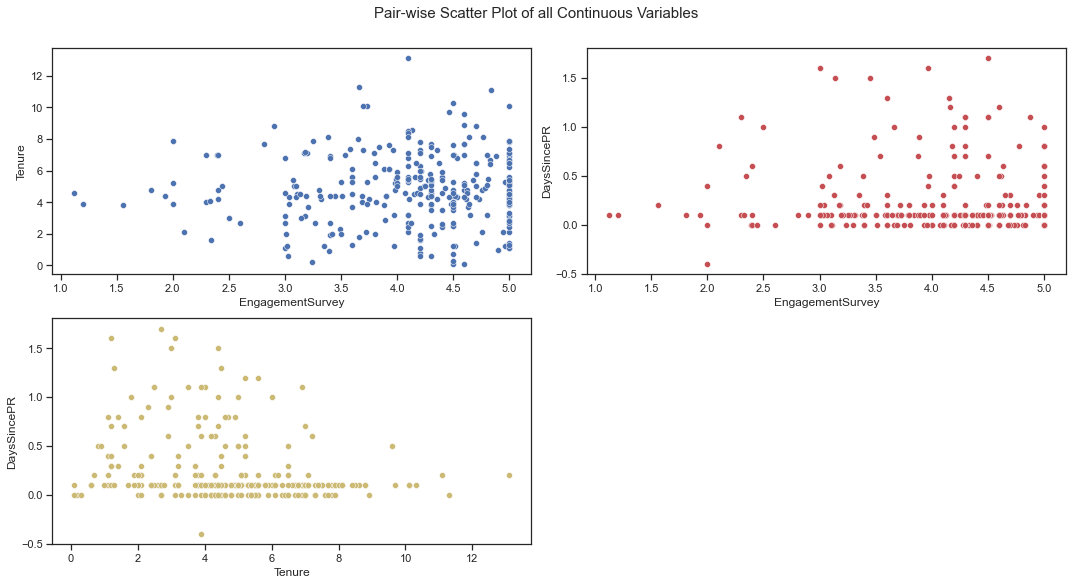

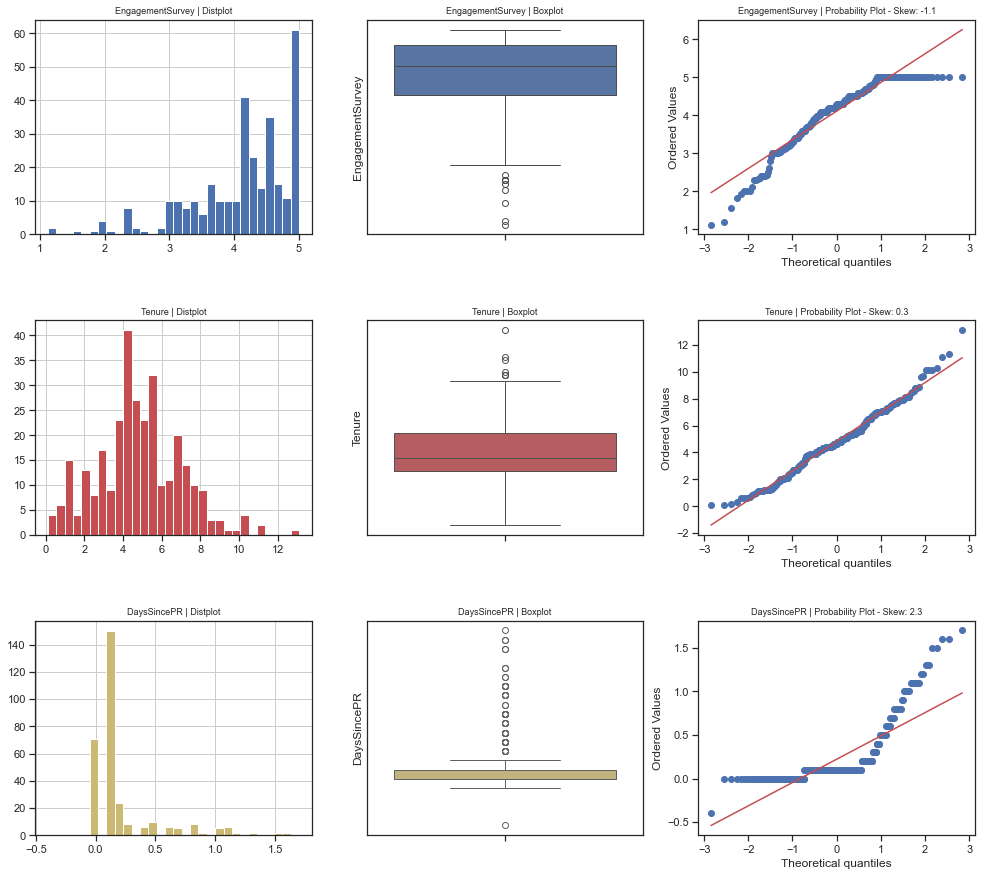

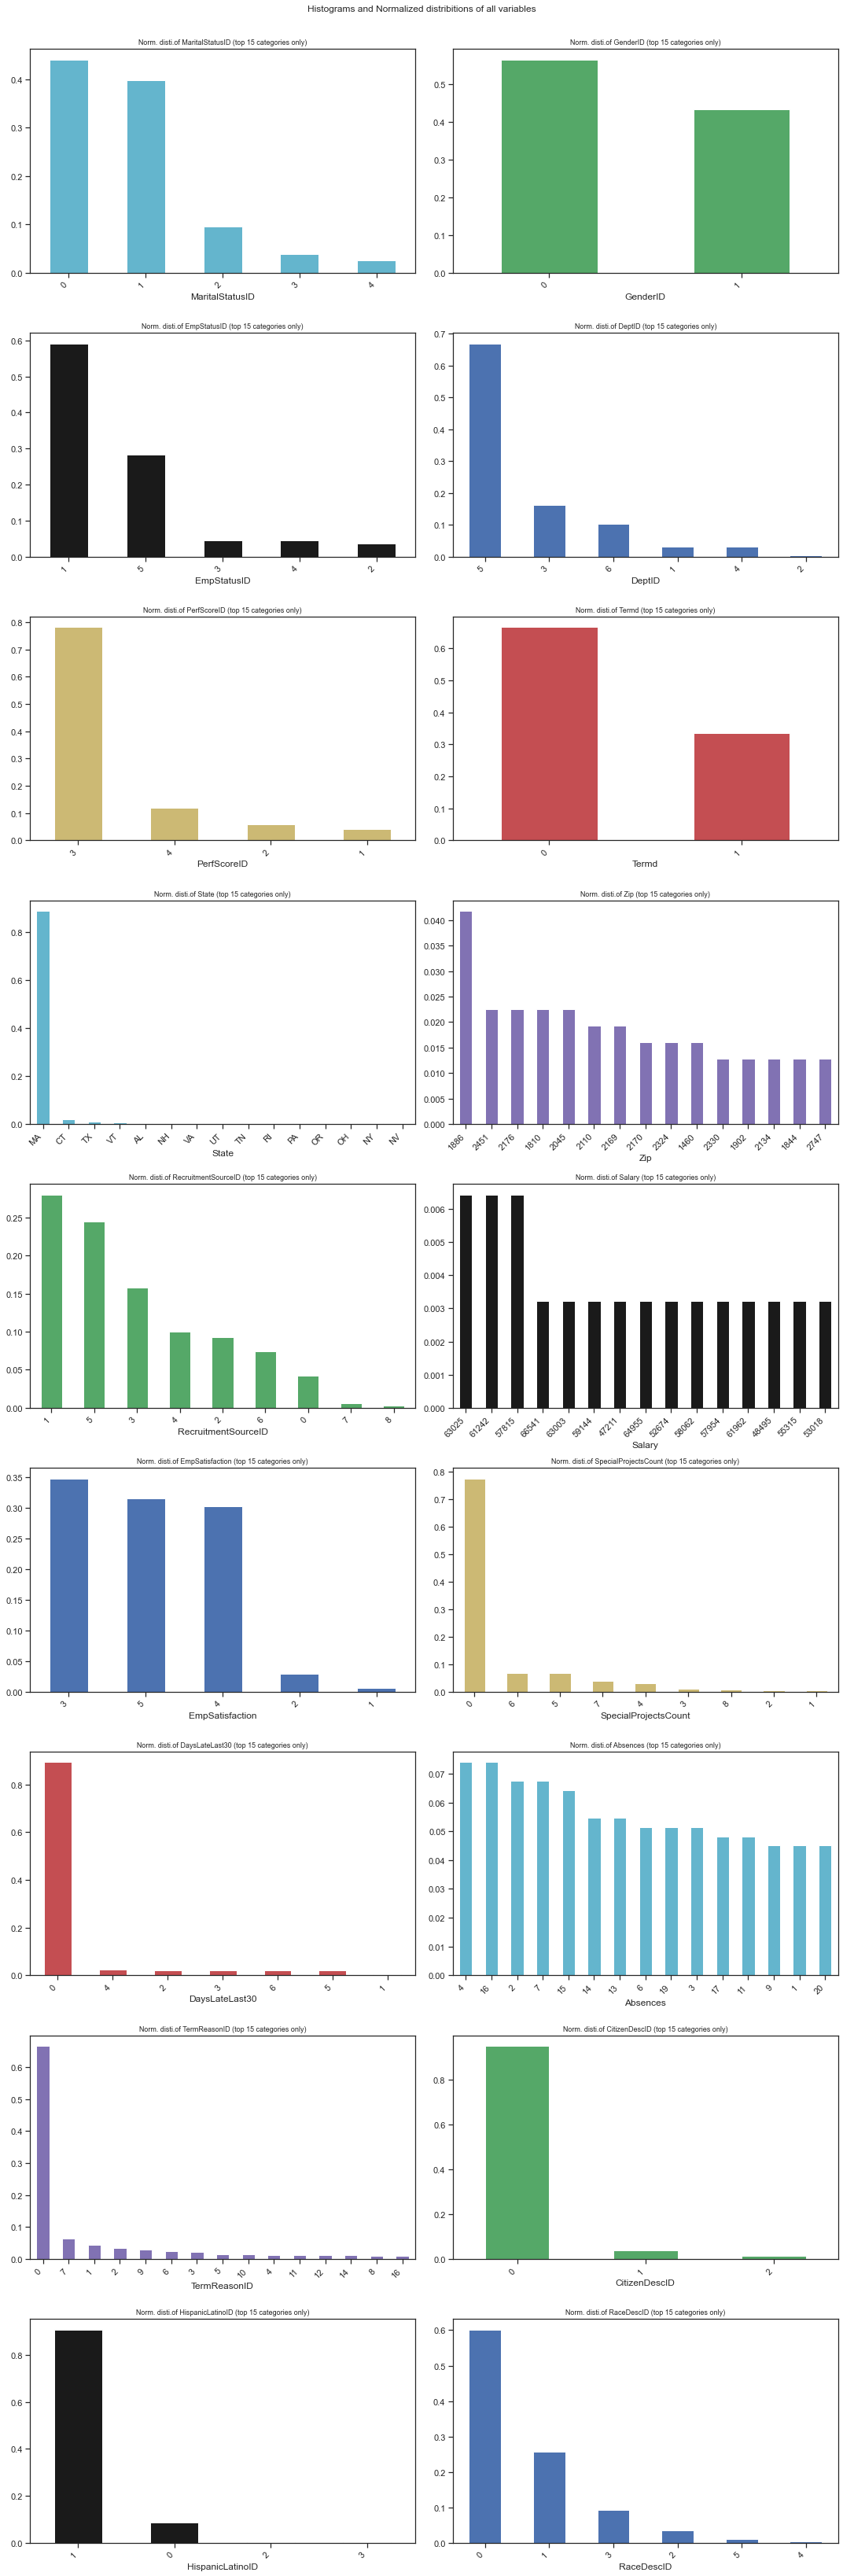

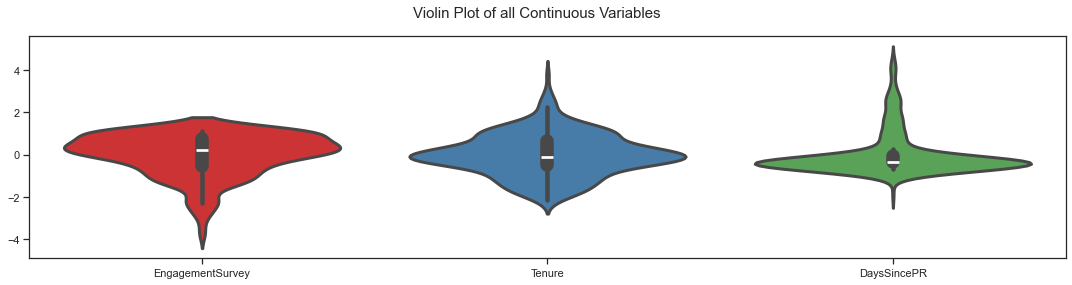

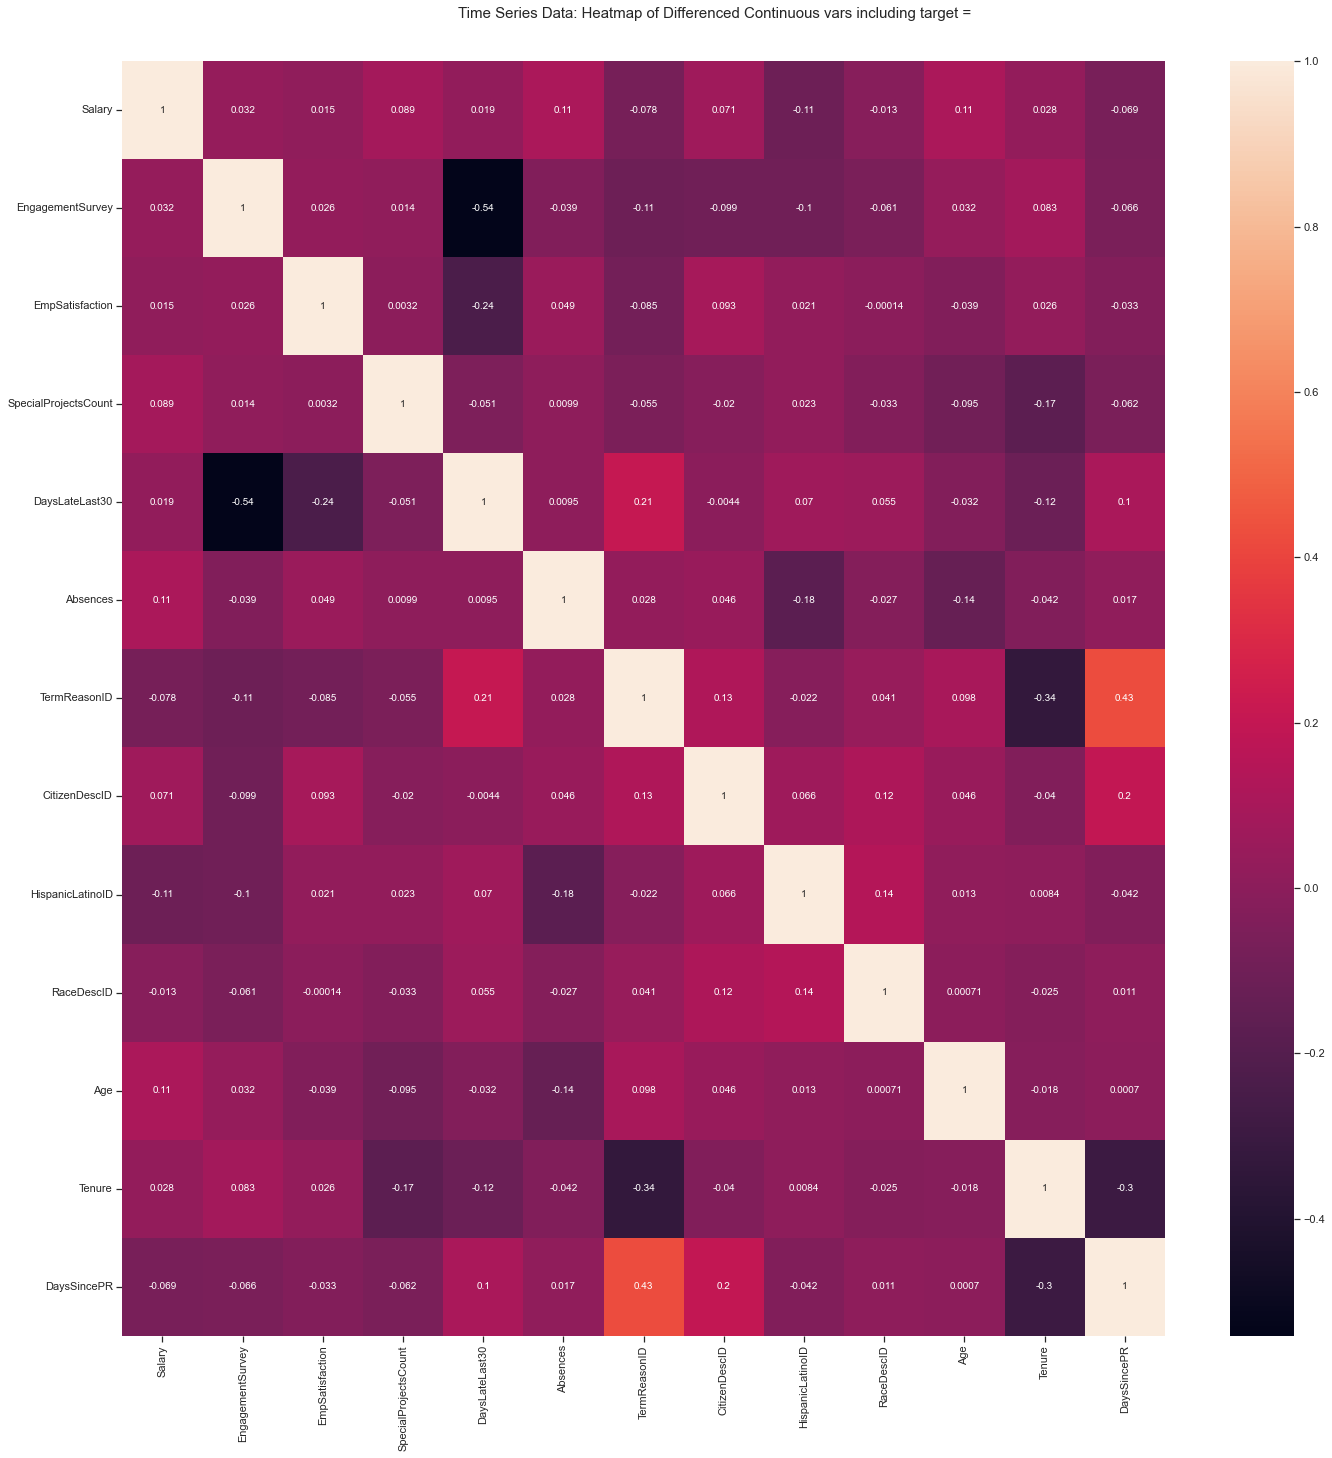

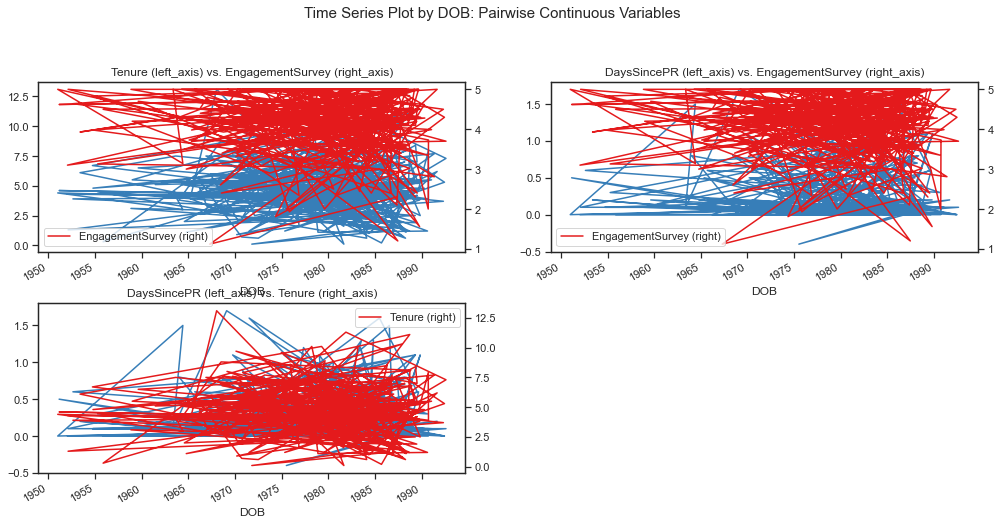

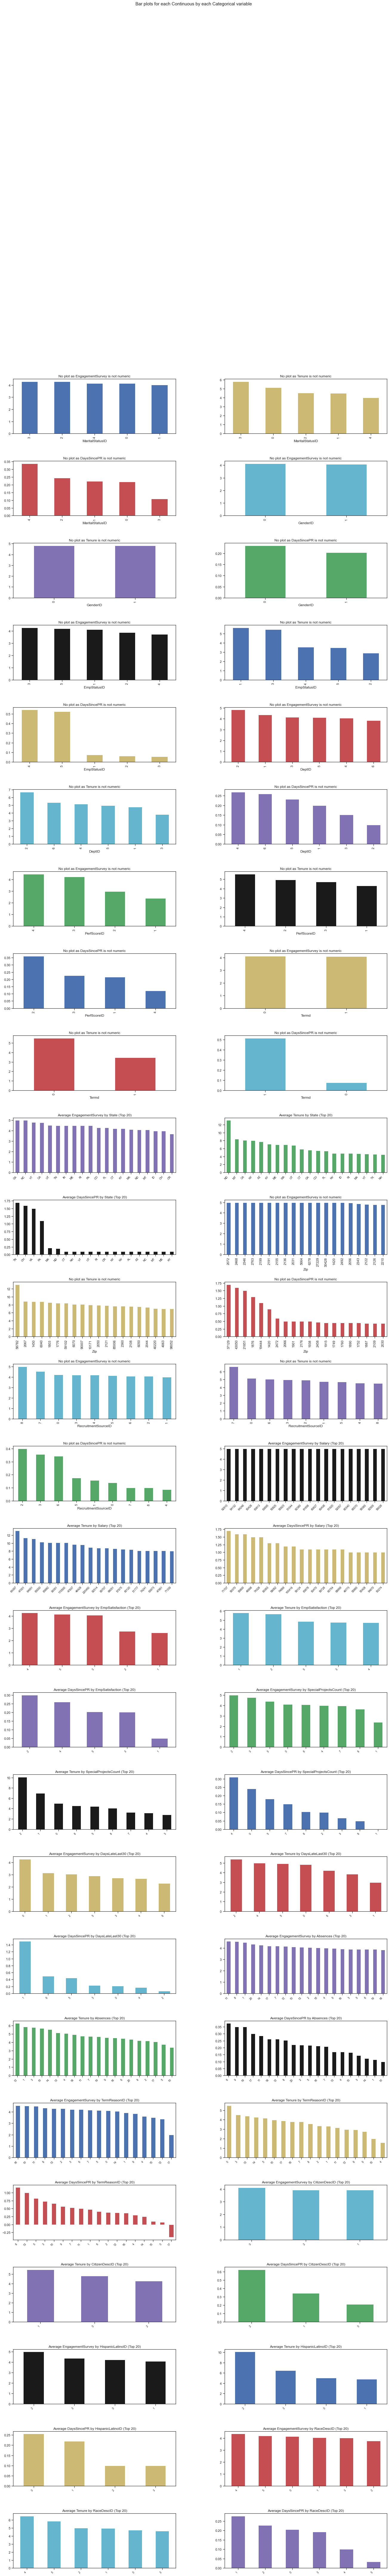

All Plots done
Time to run AutoViz = 11 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [49]:
# Utilize AutoViz for easy summary reporting
%matplotlib inline
AV=AutoViz_Class()
viz = AV.AutoViz(cleaned_df)

# Turnover Prediction
## Below we show example code of using different model types and their efficacy.
### 1. Logistic Regression: Linear, interpretable. Limited by linear assumption of relationships but fast and easy to gauge variable strength and equation-ize
### 2. Random Forest: Non-linear, ensemble. Best with larger models. Can overfit easily.
### 3. XGBoost: Non-linear, gradient boosting machine. High accuracy, good for missing values, feature importance. Does require tuning.
### 4. Decision Tree: Tree-based, hierarchical. Simple and a good fit to most datasets. Can overfit easily.


In [50]:
# Separate features and target
X = df[cat_cols + continuous_cols]
y = df['Termd']


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 2. Build preprocessing pipeline ---

# For categorical columns: OneHotEncode (you could try label encoding but OHE is more common here)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# For continuous columns: scale (especially important for Logistic Regression)
continuous_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('cont', continuous_transformer, continuous_cols)
    ])

# --- 3. Define models with pipelines ---

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
]) for name, model in models.items()}

# --- 4. Train, predict, and evaluate ---

results = []

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    print(f"{name} classification report:\n{classification_report(y_test, y_pred)}\n")

# --- 5. Display summary ---

results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("Model comparison:")
print(results_df)

Training Logistic Regression...
Logistic Regression classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.90      0.86      0.88        21

    accuracy                           0.92        63
   macro avg       0.92      0.90      0.91        63
weighted avg       0.92      0.92      0.92        63


Training Random Forest...
Random Forest classification report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       0.94      0.81      0.87        21

    accuracy                           0.92        63
   macro avg       0.93      0.89      0.91        63
weighted avg       0.92      0.92      0.92        63


Training Decision Tree...
Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        42
           1       0.75      0.86 

In [51]:
# Define hyperparameter grids (examples, you can expand/tune further)
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1]
    }
}

best_models = {}

for name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best params for {name}: {grid_search.best_params_}")
    best_models[name] = grid_search.best_estimator_

# Evaluate tuned models
results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    print(f"{name} classification report after tuning:\n{classification_report(y_test, y_pred)}\n")

results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("Tuned model comparison:")
print(results_df)

Running GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Running GridSearchCV for Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Running GridSearchCV for Decision Tree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_split': 10}
Running GridSearchCV for XGBoost...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 1}
Logistic Regression classification report after tuning:
              precision    reca

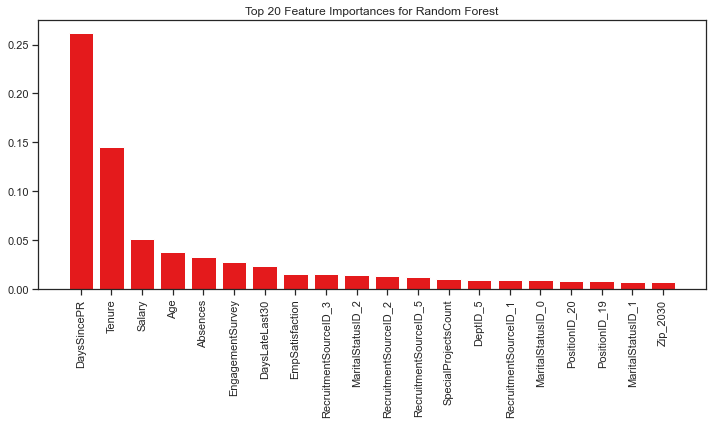

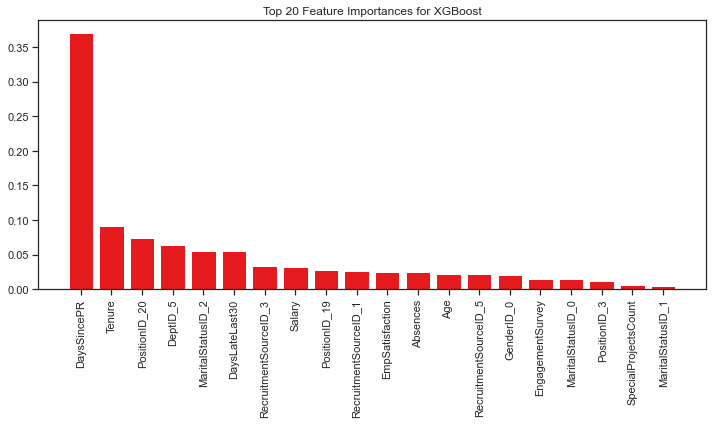

In [52]:
def plot_feature_importance(model, model_name, preprocessor, top_n=20):
    # Extract feature names from preprocessor
    ohe = preprocessor.named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(cat_cols)
    features = np.concatenate([cat_features, continuous_cols])
    
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
    else:
        print(f"No feature importances found for {model_name}")
        return
    
    # Sort feature importances
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(10,6))
    plt.title(f"Top {top_n} Feature Importances for {model_name}")
    plt.bar(range(top_n), importances[indices], align='center')
    plt.xticks(range(top_n), features[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot for Random Forest
plot_feature_importance(best_models['Random Forest'], 'Random Forest', best_models['Random Forest'].named_steps['preprocessor'])

# Plot for XGBoost
plot_feature_importance(best_models['XGBoost'], 'XGBoost', best_models['XGBoost'].named_steps['preprocessor'])

# CONCLUSION
### Before Tuning
* All models performed well with accuracy around 86-92%.
* Random Forest and Logistic Regression led with ~92% accuracy.
* Decision Tree had slightly lower accuracy (~86%).
* XGBoost was close to Random Forest but a bit behind (~89% accuracy).
* Precision, recall, and F1 showed good balance, but some tradeoffs existed — e.g., Random Forest had high precision but slightly lower recall for class 1.

### After Hyperparameter Tuning
* Logistic Regression improved accuracy to ~94%, with perfect precision on class 1 and higher recall on class 0.
* Random Forest accuracy dropped slightly to ~90%, likely due to more conservative splits (min_samples_split=5) and more estimators (n=200) helping generalization but reducing slight overfitting.
* Decision Tree accuracy improved to ~92%, showing better balance after tuning max_depth and min_samples_split.
* XGBoost stayed similar (~89%), with fine-tuned learning rate and max_depth optimizing performance but not drastically changing results.

### Why the improvements happened:
* Tuning regularization (Logistic Regression’s C) and solver improved model generalization, reducing slight overfitting.
* Random Forest tuning (trees, depth, min_samples_split) controls complexity, balancing bias and variance.
* Decision Tree tuning limits overfitting by controlling tree growth.
* XGBoost tuning focused on learning rate and subsample — helps smooth learning but performance gains depend on data size and complexity.

### Potential downsides / overfitting risks:
* The small dataset (n=63) means models can overfit easily, especially complex ones like Random Forest or XGBoost.
* Logistic Regression’s perfect precision on class 1 may indicate some overfitting or class imbalance effects.
* Decision Trees are prone to overfitting without tuning; here tuning helped but it’s still a risk.
* Cross-validation and larger data would help confirm true generalization.

### Summary:
* Logistic Regression was best overall after tuning, balancing precision and recall with highest accuracy.
* Random Forest offers robust performance but slightly reduced accuracy after tuning to prevent overfitting.
* Decision Tree benefited from tuning but remains less stable.
* XGBoost showed consistent, solid but not superior results, possibly limited by data size.